In [1]:
from __future__ import annotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_axes_aligner

In [2]:
import os; 
os.chdir("..")

import pqr
from pqr.utils import partial, compose

os.chdir("./examples/")

# Introduction

In [3]:
def read_prices(country: str = "usa") -> pd.DataFrame:
    return (
        pd.read_csv(
            f"./factors/{country}/close_price.csv", 
            index_col=0, 
            parse_dates=True
        )
        .replace(0, np.nan)
        .iloc[:-1]  # костыль - обновить данные и убрать
    )


def backtest_momentum_portfolio(
    prices: pd.DataFrame,
    universe: pd.DataFrame,
    looking: int = 12,
    lag: int = 0,
    holding: int = 12,
    q: float = 0.3,
    name: str = "Momentum Portfolio",
) -> pd.DataFrame:        
    dynamic_transform = compose(
        partial(pqr.filter, universe=universe),
        partial(pqr.look_back_pct_change, period=looking),
        partial(pqr.lag, period=lag),
        partial(pqr.hold, period=holding),
    )
    mom = dynamic_transform(prices)
    
    return pqr.backtest_portfolio(
        prices=prices,
        longs=pqr.quantiles(mom, min_q=1 - q, max_q=1),
        shorts=None,
        allocation=pqr.equal_weights,
        name=name,
    )

## Opportunities and Selectivity

In [4]:
from pqr.tests.opportunities import get_extreme_portfolio


def plot_figure_1(
    portfolio: pd.DataFrame,
    prices: pd.DataFrame,
    universe: pd.DataFrame,
) -> None:
    best_portfolio = get_extreme_portfolio(
        base_portfolio=portfolio,
        prices=prices,
        universe=universe,
        allocation=pqr.equal_weights,
        how="best",
    )
    worst_portfolio = get_extreme_portfolio(
        base_portfolio=portfolio,
        prices=prices,
        universe=universe,
        allocation=pqr.equal_weights,
        how="worst",
    )
    
    best_compounded_returns = pqr.metrics.compounded_returns(best_portfolio)
    worst_compounded_returns = pqr.metrics.compounded_returns(worst_portfolio)
    
    
    plt.figure(figsize=(10, 4))
    
    best_compounded_returns.plot(label="Best Portfolio")
    worst_compounded_returns.plot(label="Worst Portfolio")
    plt.fill_between(
        best_compounded_returns.index,
        best_compounded_returns,
        worst_compounded_returns, 
        facecolor="none",
        hatch="/",
        edgecolor="black", 
        linewidth=0.0,
    )
    plt.yscale("symlog")
    
    plt.xlabel("Date")
    plt.ylabel("Compounded Returns (log scale)")
    plt.legend()

In [5]:
usa_prices = read_prices("usa")
usa_universe = usa_prices > 10

usa_12012 = backtest_momentum_portfolio(
    prices=usa_prices,
    universe=usa_universe,
    looking=12,
    lag=0,
    holding=12,
    q=0.3,
    name="USA CS Momentum 12-0-12 Long only 30% quantile (EW)",
)

In [10]:
usa_12012["returns"].resample("BQ").apply(lambda arr: pqr.metrics.compounded_returns(arr).iat[-1])

USA CS Momentum 12-0-12 Long only 30% quantile (EW)
1974-03-29   -0.027860
1974-06-28   -0.151914
1974-09-30   -0.211729
1974-12-31    0.065473
1975-03-31    0.251870
                ...   
2020-09-30    0.088844
2020-12-31    0.218622
2021-03-31    0.033144
2021-06-30    0.062821
2021-09-30   -0.011225
Freq: BQ-DEC, Name: returns, Length: 191, dtype: float64

In [17]:
usa_prices

,1-800 CONTACTS DEAD,1-800-FLOWERS.COM 'A',10X CAPITAL VENTURE ACQ UNITS,10X CAPITAL VENTURE ACQUISITION II UNITS,10X GENOMICS A,180 LFSE.EQ.WARRT. EXP 7TH NOV 2025,180 LIFE SCIENCES,1847 GOEDEKER,1895 BANCORP OF WISCONSIN,1ST BANC. IND DEAD,...,ZW DATA ACTION TECHNOLOGIES,ZWEIG STRATEGY FUND,ZWEIG TF.FD.LNG.TM.PRTF.,ZWEIG TF.FD.TM.PRTF.,ZYCON DEAD,ZYGO DEAD,ZYMOGENETICS DEAD,ZYNERBA PHARMACEUTICALS,ZYNEX,ZYTEC DEAD
Name,,,,,,,,,,,,,,,,,,,,,
1973-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31,NaN,27.610,10.72,NaN,181.00,0.9500,6.56,8.70,14.2394,NaN,...,2.64,NaN,NaN,NaN,NaN,NaN,NaN,4.65,15.27,NaN
2021-04-30,NaN,31.975,10.80,NaN,197.80,2.1500,9.65,7.50,14.4800,NaN,...,1.99,NaN,NaN,NaN,NaN,NaN,NaN,4.41,14.77,NaN
2021-05-31,NaN,30.470,10.75,NaN,180.00,1.6200,8.54,1.82,14.7450,NaN,...,1.77,NaN,NaN,NaN,NaN,NaN,NaN,5.68,15.22,NaN


In [21]:
list(zip((1, 2), (2, 3), (3, 4)))

[(1, 2, 3), (2, 3, 4)]

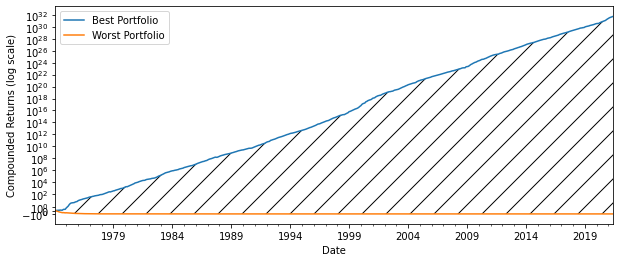

In [6]:
plot_figure_1(
    portfolio=usa_12012,
    prices=usa_prices,
    universe=usa_universe,
)

## Opportunities and Market Timing

In [7]:
def plot_figure_2(
    portfolio_1: pd.DataFrame,
    portfolio_2: pd.DataFrame,
) -> None:
    best_returns = portfolio_1["returns"].copy()    
    best_returns[portfolio_1["returns"] > portfolio_2["returns"]] = portfolio_1["returns"]
    best_returns[portfolio_1["returns"] < portfolio_2["returns"]] = portfolio_2["returns"]
    
    worst_returns = portfolio_1["returns"].copy()
    worst_returns[portfolio_1["returns"] < portfolio_2["returns"]] = portfolio_1["returns"]
    worst_returns[portfolio_1["returns"] > portfolio_2["returns"]] = portfolio_2["returns"]
    
    plt.figure(figsize=(10, 4))
    
    best_returns.plot(label="Best Market", color="green")
    worst_returns.plot(label="Worst Market", color="red")
    plt.fill_between(
        best_returns.index,
        best_returns,
        worst_returns, 
        facecolor="none",
        hatch="|",
        edgecolor="black", 
        linewidth=0.0,
    )
    
    plt.xlabel("Date")
    plt.ylabel("Returns")
    
    plt.legend()

In [8]:
usa_101 = backtest_momentum_portfolio(
    prices=usa_prices,
    universe=usa_universe,
    looking=1,
    lag=0,
    holding=1,
    q=0.3,
    name="USA CS Momentum 1-0-1 Long only 30% quantile (EW)",
)

# japan_prices = pd.read_csv("japan")
# japan_universe = japan_prices.notnull()  # ?
# japan_101 = backtest_momentum_portfolio(
#     prices=japan_prices,
#     universe=japan_universe,
#     looking=1,
#     lag=0,
#     holding=1,
#     q=0.3,
#     name="Japan CS Momentum 1-0-1 Long only 30% quantile (EW)",
# )

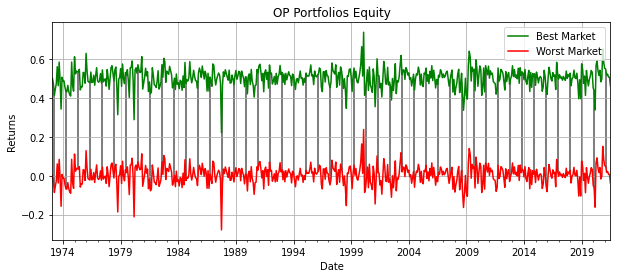

In [9]:
plot_figure_2(
    usa_101,
    usa_101 + 0.5,  # здесь взять портфель по Японии
)

## Opportunities Risk Premia

In [15]:
def plot_universe_premia(
    portfolio: pd.DataFrame,
    prices: pd.DataFrame,
    universe_filters: tuple[int] = (0, 2, 5),
) -> None:
    plt.figure(figsize=(10, 4))
    
    for universe_filter in universe_filters:
        best_portfolio = get_extreme_portfolio(
            base_portfolio=portfolio,
            prices=prices,
            universe=prices > universe_filter,
            allocation=pqr.equal_weights,
            how="best",
        )
        worst_portfolio = get_extreme_portfolio(
            base_portfolio=portfolio,
            prices=prices,
            universe=prices > universe_filter,
            allocation=pqr.equal_weights,
            how="worst",
        )

        pqr.metrics.compounded_returns(best_portfolio).plot(label=f"> {universe_filter}$ (Best)")
        pqr.metrics.compounded_returns(worst_portfolio).plot(label=f"> {universe_filter}$ (Worst)")

    plt.xlabel("Date")
    plt.ylabel("Compounded Returns (log scale)")
    plt.yscale("symlog")

    plt.legend()

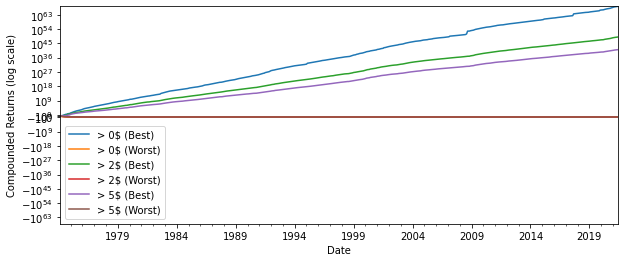

In [16]:
plot_universe_premia(
    portfolio=usa_12012,
    prices=usa_prices,
)

In [113]:
def plot_concentration_premia(
    prices: pd.DataFrame,
    universe: pd.DataFrame,
    quantiles: tuple[float] = [0.05, 0.1, 0.25],
) -> None:
    plt.figure(figsize=(16, 9))
        
    for q in quantiles:
        portfolio = backtest_momentum_portfolio(
            prices=prices,
            universe=universe,
            looking=12,
            lag=0,
            holding=12,
            q=q,
        )
        
        best_portfolio = get_extreme_portfolio(
            base_portfolio=portfolio,
            prices=prices,
            universe=universe,
            allocation=pqr.equal_weights,
            how="best",
        )
        worst_portfolio = get_extreme_portfolio(
            base_portfolio=portfolio,
            prices=prices,
            universe=universe,
            allocation=pqr.equal_weights,
            how="worst",
        )

        pqr.metrics.compounded_returns(best_portfolio).plot(label=f"{round(q * 100)}% quantiles (Best)")
        pqr.metrics.compounded_returns(worst_portfolio).plot(label=f"{round(q * 100)}% quantiles (Worst)")
        
    plt.xlabel("Date")
    plt.ylabel("Compounded Returns (log scale)")
    plt.yscale("symlog")
    plt.ylim(bottom=-1.5)


    plt.legend()

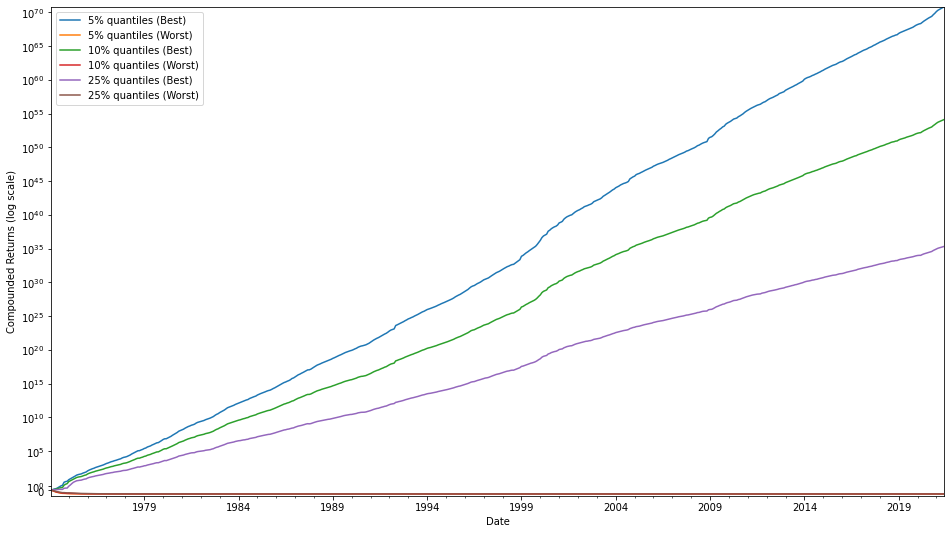

In [114]:
plot_concentration_premia(
    prices=usa_prices,
    universe=usa_universe,
)

# 

In [25]:
def plot_figure_4(
    portfolio: pd.DataFrame,
    prices: pd.DataFrame,
    universe: pd.DataFrame,
    benchmark: pd.DataFrame,
    window: int = 12,
) -> None:
    op_est = pqr.tests.opportunities_test(
        base_portfolio=portfolio,
        prices=prices,
        universe=universe,
        allocation=pqr.equal_weights,
    ).rolling(window).mean().iloc[window:]
    
    talpha = pqr.metrics.trailing_alpha(
        portfolio,
        benchmark,
        annualizer=12,
        window=window,
    )
    
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html
    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Trailing Alpha")
    ax1.plot(talpha, color="red")
    ax1.axhline(0)
#     ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel("Opportunities Test Estimate")  # we already handled the x-label with ax1
    ax2.plot(op_est, color="green")
#     ax2.tick_params(axis='y', labelcolor=color)
    mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0.5, 0.5)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

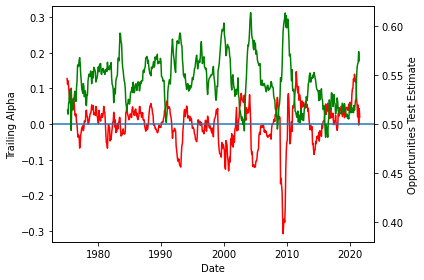

In [26]:
plot_figure_4(
    portfolio=usa_12012,
    prices=usa_prices,
    universe=usa_universe,
    benchmark=pqr.universe_as_benchmark(
        prices=usa_prices,
        universe=usa_universe,
        allocation=pqr.equal_weights,
    )
)

In [52]:
def momentum_table(
    prices: pd.DataFrame,
    universe: pd.DataFrame,
    periods: list[int],
    metrics: dict,
) -> pd.DataFrame:
    results = {
        metric: pd.DataFrame(
            index=pd.Series(periods, name="Lookback Period (months)"), 
            columns=pd.Series(periods, name="Holding Period (months)")
        ) 
        for metric in metrics
    }
    
    for looking in periods:
        for holding in periods:
            momentum_transform = compose(
                partial(pqr.filter, universe=universe),
                partial(pqr.look_back_pct_change, period=looking),
                partial(pqr.hold, period=holding)
            )
            momentum = momentum_transform(prices)
            
            portfolio = pqr.backtest_portfolio(
                prices=prices,
                longs=pqr.quantiles(momentum, min_q=0.7, max_q=1),
                shorts=None,
                allocation=pqr.equal_weights,
            )
            
            for metric_name, metric in metrics.items():
                results[metric_name].loc[looking, holding] = metric(portfolio)
                
    return results

In [53]:
t = momentum_table(
    prices=usa_prices,
    universe=usa_universe,
    periods=[1, 2, 3, 6, 12, 24, 36],
    metrics={
        "Panel A: Mean Annual Return (EW)": pqr.metrics.fancy_format(
            pqr.metrics.mean_return,
            multiplier=100,
            precision=2,
            statistics=True,
        ),
        "Panel C: Sharpe Ratio": pqr.metrics.fancy_format(
            pqr.metrics.sharpe_ratio,
            precision=2,
        )
    }
)

In [58]:
t[list(t.keys())[0]]

Holding Period (months),1,2,3,6,12,24,36
Lookback Period (months),,,,,,,
1,3.65* (1.48),4.82** (1.91),6.08*** (2.35),8.17*** (3.01),8.24*** (3.01),9.77*** (3.90),7.70*** (2.90)
2,4.55** (1.83),6.28*** (2.45),6.16*** (2.36),7.66*** (2.91),7.97*** (3.03),9.70*** (3.83),7.35*** (2.98)
3,6.41*** (2.58),6.72*** (2.69),7.86*** (3.11),7.80*** (3.12),8.96*** (3.49),9.95*** (3.94),8.44*** (3.51)
6,6.82*** (2.77),7.80*** (3.13),8.98*** (3.50),9.03*** (3.58),9.20*** (3.72),9.68*** (3.95),8.66*** (3.59)
12,8.43*** (3.53),8.82*** (3.67),9.72*** (4.02),9.07*** (3.74),8.88*** (3.68),8.16*** (3.33),8.41*** (3.65)
24,8.47*** (3.65),8.89*** (3.82),9.39*** (3.98),8.92*** (3.80),8.58*** (3.77),7.91*** (3.62),8.47*** (4.02)
36,7.17*** (3.19),7.47*** (3.31),7.94*** (3.48),7.95*** (3.48),8.15*** (3.64),8.06*** (3.63),7.00*** (3.35)


In [55]:
from openpyxl import Workbook


def panels_to_table(panels: dict[str, pd.DataFrame]) -> Workbook:
    wb = Workbook()
    ws = wb.active
    
    template = list(panels.values())[0]
    
    ws.append([None, None] + [template.columns.name])
    ws.merge_cells(start_row=1, end_row=1, 
                   start_column=3, end_column=2+len(template.columns))
    ws.append([None, None] + list(template.columns))
    
    crow = 3
    for panel_name, panel in panels.items():
        # columns header 
        ws.append([panel_name])
        ws.merge_cells(start_row=crow, end_row=crow, 
                       start_column=1, end_column=2+len(template.columns))
        
        # table values
        for row in panel.itertuples():
            index, *values = row
            ws.append([None] + [index] + values)
            
        # rows header
        ws.cell(row=crow+1, column=1).value = panel.index.name
        ws.merge_cells(start_row=crow+1, end_row=crow+len(panel.index),
                       start_column=1, end_column=1)
        
        crow += len(panel.index) + 1
        
    return wb

In [56]:
wb = panels_to_table(t)

In [57]:
wb.save("test.xlsx")

In [102]:
momentum_transform = compose(
    partial(pqr.filter, universe=usa_universe),
    partial(pqr.look_back_pct_change, period=36),
    partial(pqr.hold, period=36)
)
momentum = momentum_transform(usa_prices)

In [103]:
momentum

,1-800 CONTACTS DEAD,1-800-FLOWERS.COM 'A',10X CAPITAL VENTURE ACQ UNITS,10X CAPITAL VENTURE ACQUISITION II UNITS,10X GENOMICS A,180 LFSE.EQ.WARRT. EXP 7TH NOV 2025,180 LIFE SCIENCES,1847 GOEDEKER,1895 BANCORP OF WISCONSIN,1ST BANC. IND DEAD,...,ZW DATA ACTION TECHNOLOGIES,ZWEIG STRATEGY FUND,ZWEIG TF.FD.LNG.TM.PRTF.,ZWEIG TF.FD.TM.PRTF.,ZYCON DEAD,ZYGO DEAD,ZYMOGENETICS DEAD,ZYNERBA PHARMACEUTICALS,ZYNEX,ZYTEC DEAD
Name,,,,,,,,,,,,,,,,,,,,,
1976-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31,NaN,1.947722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-30,NaN,1.947722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-31,NaN,1.947722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
a = usa_prices.to_numpy()
pd.DataFrame((a[36:] - a[:-36]) / a[:-36])

,0,1,2,3,4,5,6,7,8,9,...,18589,18590,18591,18592,18593,18594,18595,18596,18597,18598
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,NaN,1.339831,NaN,NaN,NaN,2.958333,-0.334010,NaN,NaN,NaN,...,0.581975,NaN,NaN,NaN,NaN,NaN,NaN,-0.464902,3.504425,NaN
543,NaN,1.517717,NaN,NaN,NaN,9.750000,-0.025253,NaN,NaN,NaN,...,-0.271062,NaN,NaN,NaN,NaN,NaN,NaN,-0.570594,3.615625,NaN
544,NaN,1.418254,NaN,NaN,NaN,4.787781,-0.139980,NaN,NaN,NaN,...,-0.370107,NaN,NaN,NaN,NaN,NaN,NaN,-0.467666,3.831746,NaN
545,NaN,1.539442,NaN,NaN,NaN,5.379655,0.006036,NaN,NaN,NaN,...,-0.206349,NaN,NaN,NaN,NaN,NaN,NaN,-0.456879,4.009677,NaN


In [84]:
usa_prices["10X GENOMICS A"]["2019":].shape

(31,)